## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import sklearn.metrics as metrics
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from joblib import dump, load

## Data Overview

In [2]:
df = pd.read_csv('Data/creditcard.csv')
print(f"Original: {df.shape}")

print(f"Null values? {df.isnull().values.any()}")
df = df.drop_duplicates(subset=None, keep='first', inplace=False)
print(f"After removing depulicates: {df.shape}")

df.describe()

Original: (284807, 31)
Null values? False
After removing depulicates: (283726, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


## Scale Time and Amount

In [3]:
scaled_time = RobustScaler().fit_transform(df['Time'].values.reshape(-1,1))
scaled_amount = RobustScaler().fit_transform(df['Amount'].values.reshape(-1,1))

df.insert(0, 'scaled_time', scaled_time)
df.insert(1, 'scaled_amount', scaled_amount)

data = df.drop(['Time','Amount'], axis=1)
data.describe()

,scaled_time,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,0.118912,0.924387,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,...,0.000187,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,0.001667
std,0.557988,3.482123,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,...,0.769984,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,0.040796
min,-0.995290,-0.305938,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,...,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000
25%,-0.358286,-0.228063,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,...,-0.211469,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,0.000000
50%,0.000000,0.000000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,...,-0.062353,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,0.000000
75%,0.641714,0.771937,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,...,0.133207,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,0.000000
max,1.035329,356.962314,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,...,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,1.000000


## Change label from {0, 1} to {-1,+1}

In [4]:
data['Class'].replace(0, -1, inplace=True)

## Check labels

num of fraud: 473; num of normal: 283253


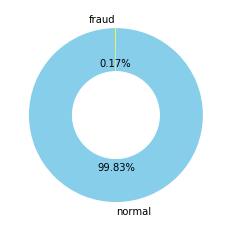

In [5]:
fraud = data[data['Class']==1]
normal = data[data['Class']==-1]
print(f"num of fraud: {len(fraud)}; num of normal: {len(normal)}")

labels ='fraud', 'normal'
size = [len(fraud), len(normal)]
 
# Create a circle for the center of the plot
my_circle = plt.Circle((0,0), 0.5, color='white')
plt.pie(size, labels=labels, colors=['yellow','skyblue'], autopct='%1.2f%%', startangle=90)
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

## Set up for training
### Set up 5-fold cross validation

In [6]:
X = data.drop(columns = ['Class'])
y = data['Class']
cv = KFold(shuffle=True)

### Set classifiers

In [7]:
classifiers = {    
    "LOF" : LocalOutlierFactor(n_neighbors=20, novelty = True),
    "SVM-rbf" : SVC(),  
    "SVM-poly" : SVC(kernel="poly")
}

### Set score names

In [8]:
score_names = ["time","accuracy","precision","recall","f1"]

###  Set a function to get the scores

In [9]:
def getScores(classifier_name, train_x, train_y, test_x, test_y):
    classifier = classifiers[classifier_name]
    start = time.time()
    classifier = classifier.fit(train_x, train_y)
    end = time.time()
    exe_time = end - start
    
    pred = classifier.predict(test_x)
    
    # Originally, -1 is the outlier for LOF output
    # Swap the label so that 1 is the outlier for LOF
    if(classifier_name=="LOF"):
        pred[pred==-1] = 0
        pred[pred==1] = -1
        pred[pred==0] = 1
       
    acc = metrics.accuracy_score(test_y, pred)
    pre = metrics.precision_score(test_y, pred, zero_division=1)
    rec = metrics.recall_score(test_y, pred, zero_division=1)
    f1 = metrics.f1_score(test_y, pred, zero_division=1)
    return [exe_time, acc, pre, rec, f1]



### Set a function to get average score of cross validation

In [10]:
def avgScore(the_results):
    the_sums = [0]*len(the_results[0])
    for r in the_results:
        for i in range(len(r)):
            the_sums[i]+=r[i]
    
    return [the_sum/len(the_results) for the_sum in the_sums] 



## Training
### Get 5-folds for cross validation and resampling

In [11]:
folds_origin = []
folds_re1 = []
folds_re2 = []
folds_re3 = []
times = []
for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    print(f"Number of fraud in test case: {len(y_test[y_test==1])}")
    folds_origin.append([X_train, X_test, y_train, y_test])
    
    #resampling 1: under + SMOTE, final ratio 0.5:
    under = RandomUnderSampler(sampling_strategy=0.0026)
    X_train_re, y_train_re = under.fit_resample(X_train, y_train)
    start1 = time.time()
    over = SMOTE(sampling_strategy=0.5)
    X_train_re1, y_train_re1 = over.fit_resample(X_train_re, y_train_re)
    end1 = time.time()
    exe_time1 = end1 - start1
    folds_re1.append([X_train_re1, X_test, y_train_re1, y_test])
    
    #resampling 2: under + SMOTE + ENN, final ratio 0.5:
    start2 = time.time()
    enn = EditedNearestNeighbours(sampling_strategy='all')
    X_train_re2, y_train_re2 = enn.fit_resample(X_train_re1, y_train_re1)
    end2 = time.time()
    exe_time2 = end2 - start2 + exe_time1
    folds_re2.append([X_train_re2, X_test, y_train_re2, y_test])

    #resampling 3: under + SMOTE + ENN, final ratio 1:
    start3 = time.time()
    over = SMOTEENN()
    X_train_re3, y_train_re3 = over.fit_resample(X_train_re, y_train_re)
    end3 = time.time()
    exe_time3 = end3 - start3
    folds_re3.append([X_train_re3, X_test, y_train_re3, y_test])
    
    times.append([exe_time1, exe_time2, exe_time3])
    
# store the folds for original and different re-samplings
folds = {
    "Original" : folds_origin,
    "SMOTE0.5" : folds_re1,
    "SMOTEENN0.5" : folds_re2,
    "SMOTEENN" : folds_re3
}

# print average time for original and different re-samplings
i = 0
for fold in folds:
    if(fold!="Original"):
        print(f"{fold} avg exe time: {avgScore(times)[i]}")
        i+=1



Number of fraud in test case: 90
Number of fraud in test case: 83
Number of fraud in test case: 113
Number of fraud in test case: 91
Number of fraud in test case: 96
SMOTE0.5 avg exe time: 0.2531956672668457
SMOTEENN0.5 avg exe time: 326.11186637878416
SMOTEENN avg exe time: 311.15507011413575


### Training models and get result

In [12]:
for clf_name in classifiers:
    print(f"\n{clf_name}", end='\t')
    
    avgs = []
    # for each data set
    for fold_name in folds:
        print(fold_name, end='\t')
        fold = folds[fold_name]
        results =[]
        # train each fold
        for f in fold:
            X_train, X_test, y_train, y_test = f
            results.append(getScores(clf_name, X_train, y_train, X_test, y_test))
        # get average scores
        avgs.append(avgScore(results))
       
    # print result
    for i in range(len(score_names)):
        print(f"\n{score_names[i]}", end='\t')
        for avg in avgs:
            print(f"{avg[i]}",end='\t') 



LOF	Original	SMOTE0.5	SMOTEENN0.5	SMOTEENN	
time	1081.4808132171615	674.77177171707123	607.84094219207701	612.81272993087702	
accuracy	0.9503429367534671	0.9403826151527992	0.9398045918994651	0.9369708695708333	
precision	0.0036331341135821	0.0226564940065811	0.0224441015789243	0.0220302415137672	
recall	0.1050188010950081	0.8267920607842242	0.8267920607842242	0.8492751774708822	
f1	0.0070209785010323	0.0440906503791711	0.0436883659850328	0.0429339363164105	
SVM-rbf	Original	SMOTE0.5	SMOTEENN0.5	SMOTEENN	
time	249.52053050994874	220.74379439353942	217.0309534072876	543.3579759120942	
accuracy	0.9994184531387209	0.9943149334521413	0.9939483826373389	0.9840832363387747	
precision	0.942889832005485	0.2109167402142774	0.20056415235799974	0.08633467860900018	
recall	0.6965123652247813	0.8604333475429808	0.8650407882949998	0.8776038584953447	
f1	0.7993889919920013	0.3378030268991867	0.32471691381580553	0.15658192384329256	
SVM-poly	Original	SMOTE0.5	SMOTEENN0.5	SMOTEENN	
time	52.17299256822

## Save the models
### Save the testing data

In [13]:
X_training, X_testing, y_training, y_testing = train_test_split(X, y, test_size=0.3)
test_data = pd.concat([X_testing, y_testing], axis=1, sort=False)
test_data.to_csv(r'Data/creditcard_testing.csv', index = False)

### Original without re-sampling

In [14]:
for clf_name in classifiers:
        filename = "SavedModels/" + clf_name + ".joblib"
        clf = classifiers[clf_name] 
        clf.fit(X_training, y_training)
        dump(clf, filename)
        print(f"{filename} saved.")

SavedModels/LOF.joblib saved.
SavedModels/SVM-rbf.joblib saved.
SavedModels/SVM-poly.joblib saved.


### With re-sampling

In [15]:
under_s = RandomUnderSampler(sampling_strategy=0.0026)
X_training_re, y_training_re = under_s.fit_resample(X_training, y_training)
over_s = SMOTEENN(sampling_strategy=0.5)
X_training_re, y_training_re = over_s.fit_resample(X_training_re, y_training_re)

for clf_name in classifiers:
        filename = "SavedModels/" + clf_name + "_re.joblib"
        clf = classifiers[clf_name] 
        clf.fit(X_training_re, y_training_re)
        dump(clf, filename)
        print(f"{filename} saved.")

SavedModels/LOF_re.joblib saved.
SavedModels/SVM-rbf_re.joblib saved.
SavedModels/SVM-poly_re.joblib saved.
